In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Мы будем работать с данными агрегатора такси [Sigma Cabs](https://www.kaggle.com/datasets/arashnic/taxi-pricing-with-mobility-analytics). В зависимости от характеристик поездки требуется предсказать один из трех типов повышенного ценообразования: [1, 2, 3]. Таким образом, это поможет компании оптимально мэтчить такси и клиентов. 

In [129]:
df = pd.read_csv('sigma_cabs.csv')
df.shape

(131662, 14)

In [130]:
# Занесем индекс колонку
df = df.set_index('Trip_ID')
df.head()

,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
Trip_ID,,,,,,,,,,,,,
T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


Описание признаков:

1. **Trip_ID**: ID for TRIP
2. **Trip_Distance**: The distance for the trip requested by the customer
3. **TypeofCab**: Category of the cab requested by the customer
4. **CustomerSinceMonths**: Customer using cab services since n months; 0 month means current month
5. **LifeStyleIndex**: Proprietary index created by Sigma Cabs showing lifestyle of the customer based on their behaviour
6. **ConfidenceLifeStyle_Index**: Category showing confidence on the index mentioned above
7. **Destination_Type**: Sigma Cabs divides any destination in one of the 14 categories.
8. **Customer_Rating**: Average of life time ratings of the customer till date
9. **CancellationLast1Month**: Number of trips cancelled by the customer in last 1 month
10. **Var1**, **Var2** and **Var3**: Continuous variables masked by the company. Can be used for modelling purposes
11. **Gender**: Gender of the customer

**SurgePricingType**: Target (can be of 3 types)


### EDA 
Заполните пропуски в вещественных признаках медианой, а в категориальных - самым популярным классом. Изобразите марицу корреляций и выведите топ5 пар самых коррелированных признаков.

Так как в сумме уникальных значений различных категориальных признаков окажется не супер-много, примените `One-Hot-Encoding` для них. Не забудьте в методе `pd.get_dummies` указать параметр `drop_first=True`.

In [131]:
### Your code is here
num_cols, obj_cols = [], []
for col in df.columns:
    if df[col].dtype in ('float64', 'int64'):
        df[col] = df[col].fillna(df[col].median())
        if col != 'Surge_Pricing_Type':
            num_cols.append(col)
    else:
        df[col] = df[col].fillna(df[col].mode()[0])
        obj_cols.append(col)
        
for col in df.columns:
    if df[col].dtype == object:
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(columns=[col])

In [132]:
corrs = df.corr().abs().unstack().sort_values()
corrs[corrs < 1].tail().apply(lambda x: round(x, 3))

Trip_Distance                  Life_Style_Index                 0.468
Confidence_Life_Style_Index_C  Confidence_Life_Style_Index_B    0.566
Confidence_Life_Style_Index_B  Confidence_Life_Style_Index_C    0.566
Var2                           Var3                             0.683
Var3                           Var2                             0.683
dtype: float64

### Training

In [133]:
np.random.seed(2022)

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [134]:
X, y = df.drop(columns=['Surge_Pricing_Type']), df['Surge_Pricing_Type']
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

**Задание 1.** Обучите One-vs-Rest Logreg. Не забудьте в шаг добавить стандартизацию данных (через `StandardScaler`) Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg. Здесь и далее округляйте до 3 знака после запятой.

Чтобы отдельно и долго не вычислять метрики, можно воспользоваться `classification_report` из `sklearn.metrics`!

In [135]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

### Your code is here
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('one_vs_all', OneVsRestClassifier(LogisticRegression()))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_all',
                 OneVsRestClassifier(estimator=LogisticRegression()))])

In [136]:
from sklearn.metrics import classification_report

y_pred = pipe.predict_proba(X_test).argmax(axis=1) + 1
print(classification_report(y_pred, y_test, digits=3))

              precision    recall  f1-score   support

           1      0.542     0.723     0.619      4029
           2      0.834     0.636     0.722     14898
           3      0.571     0.741     0.645      7406

    accuracy                          0.679     26333
   macro avg      0.649     0.700     0.662     26333
weighted avg      0.715     0.679     0.684     26333



Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()` из предложенных. Для лучшего набора гиперпараметров посчитайте те же самые метрики. Валидировать параметры необходимо по `accuracy`. В этот раз проведем настояющую процедуру Кросс-Валидации! 

Для этого в метод `fit` передадим тренировочную часть наших данных, в параметр `cv` ничего не будем передавать (по дефолту 5-fold Кросс-Валидация будет проведена), а итоговые метрики замерим на тесте!

In [137]:
param_grid = {'one_vs_all__estimator__penalty': ['l1', 'l2', 'elasticnet'],
              'one_vs_all__estimator__C': [0.001, 0.01, 0.1, 1]}

In [138]:
### Your code is here
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(pipe, param_grid, scoring='accuracy').fit(X_train, y_train)

In [139]:
grid.best_params_

{'one_vs_all__estimator__C': 0.001, 'one_vs_all__estimator__penalty': 'l2'}

In [140]:
y_pred = grid.predict_proba(X_test).argmax(axis=1) + 1
print(classification_report(y_pred, y_test, digits=3))

              precision    recall  f1-score   support

           1      0.534     0.742     0.621      3868
           2      0.839     0.635     0.723     15010
           3      0.576     0.742     0.649      7455

    accuracy                          0.681     26333
   macro avg      0.650     0.706     0.664     26333
weighted avg      0.720     0.681     0.687     26333



Изобразите три калибровочные кривые для Logistic Classifier: 0-vs-rest, 1-vs-rest, 2-vs-rest. Хорошо ли откалиброван обученный классификатор? 

Заметьте, что `predict_proba` возвращает список из вероятностей для всех наших классов!

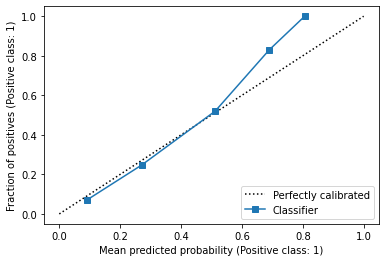

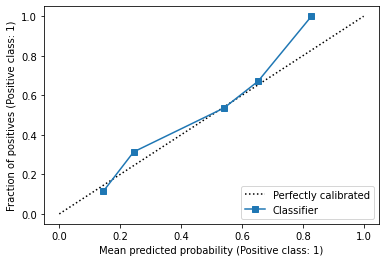

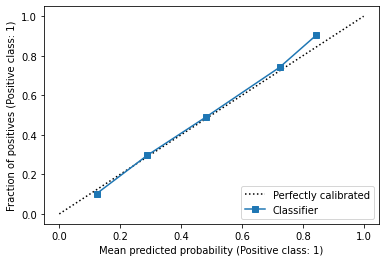

In [141]:
### Your code is here
from sklearn.calibration import CalibrationDisplay

CalibrationDisplay.from_predictions((y_test == 1).astype('int'), grid.predict_proba(X_test)[:, 0])
CalibrationDisplay.from_predictions((y_test == 2).astype('int'), grid.predict_proba(X_test)[:, 1])
CalibrationDisplay.from_predictions((y_test == 3).astype('int'), grid.predict_proba(X_test)[:, 2])

**Задание 2.** Обучите логистическую регрессию с гиперпараметрами из первого задания на полиномиальных признаках до 4 степени. Сравните метрики с первым заданием.


Пример: Пусть у нас был единственный признак 

$$
d_j = [1, 2, 3, 4]
$$

Тогда полиномиальные признаки до 4 степени от такого будут иметь вид:

$$
d_j^1 = [1, 2, 3, 4]
$$

$$
d_j^2 = [1, 4, 9, 16]
$$

$$
d_j^3 = [1, 8, 27, 64]
$$

$$
d_j^4 = [1, 16, 81, 256]
$$

P.S. Бинарные колонки нет смысла возводить в какие-то степени, поэтому возьмем исключительно вещественные из базовых. 

Для этого можно воспользоваться классическим циклом (или уроком из занятия про `Sberbank Housing Market`). Положите модифицированный датасет в переменную `X_polinomial`!

P.S.S Зачастую еще, создаваю полиномиальные фичи, учитывают "пересечения" признаков, то есть, например, из векторов признаков $d_j, d_i$ генерируют не просто новые степени $d_j^2, d_i^2, d_j^3, d_i^3...$, а еще и признаки вида $d_j \cdot d_i, d_j^2 \cdot d_i, d_j \cdot d_i^2...$, но здесь ограничьтесь просто степенями!

In [142]:
### Создание полиномиальных признаков

X_polinomial = X.copy()

### Your code is here
for col in num_cols:
    X_polinomial[col+'_2'] = X_polinomial[col]**2
    X_polinomial[col+'_3'] = X_polinomial[col]**3
    X_polinomial[col+'_4'] = X_polinomial[col]**4

In [143]:
X_pol_train, X_pol_test, y_train, y_test  = train_test_split(X_polinomial, y, 
                                                             test_size=0.2, 
                                                             shuffle=True, 
                                                             random_state=2022)

In [144]:
grid.best_params_

{'one_vs_all__estimator__C': 0.001, 'one_vs_all__estimator__penalty': 'l2'}

In [147]:
### Your code is here
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('one_vs_all', OneVsRestClassifier(LogisticRegression()))
])

pipe.set_params(**grid.best_params_).fit(X_pol_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_all',
                 OneVsRestClassifier(estimator=LogisticRegression(C=0.001)))])

In [150]:
y_pred = pipe.predict_proba(X_pol_test).argmax(axis=1) + 1
print(classification_report(y_pred, y_test, digits=3))

              precision    recall  f1-score   support

           1      0.532     0.748     0.622      3822
           2      0.837     0.636     0.723     14935
           3      0.584     0.741     0.653      7576

    accuracy                          0.682     26333
   macro avg      0.651     0.708     0.666     26333
weighted avg      0.720     0.682     0.688     26333



По аналогии с первым заданием изобразите три калибровочные кривые. Стало ли лучше?

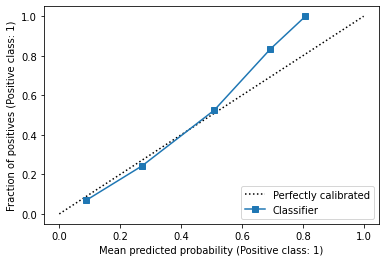

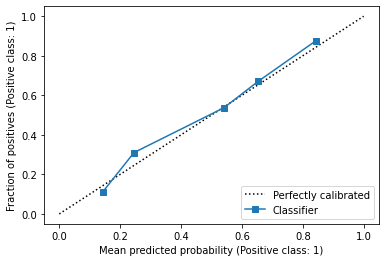

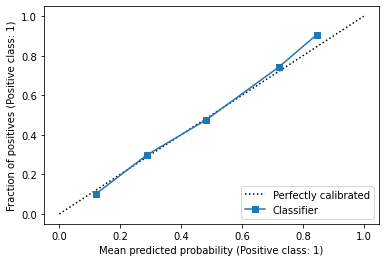

In [149]:
### Your code is here
CalibrationDisplay.from_predictions((y_test == 1).astype('int'), pipe.predict_proba(X_pol_test)[:, 0])
CalibrationDisplay.from_predictions((y_test == 2).astype('int'), pipe.predict_proba(X_pol_test)[:, 1])
CalibrationDisplay.from_predictions((y_test == 3).astype('int'), pipe.predict_proba(X_pol_test)[:, 2])

**Задание 3.** Обучите на датасете без полиномиальных признаков One-vs-One `SGDClassifier` из `sklearn.linear_model`, который использует стохастический градиентный спуск (узнаете о нем позже) и может обучать как `SVM`, так и, например, `LogReg`, если указать в качестве параметра `loss` либо `hinge`, либо `log` соответственно!

Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg.

In [67]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

In [156]:
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier

### Your code is here
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('one_vs_one', OneVsOneClassifier(SGDClassifier()))
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
print(classification_report(y_pred, y_test, digits=3))

              precision    recall  f1-score   support

           1      0.526     0.735     0.613      3846
           2      0.876     0.625     0.730     15911
           3      0.524     0.766     0.623      6576

    accuracy                          0.676     26333
   macro avg      0.642     0.709     0.655     26333
weighted avg      0.737     0.676     0.686     26333



Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()`. При этом переберите всевозможные функции потерь. Таким образом, при `loss = 'hinge'`, мы обучим SVM, при `loss = 'log'` мы обучим логистическую регрессию и т.д.

Используйте прием с Кросс-Валидацией при подборе параметров, как ранее, а также замерьте метрики на тесте.

In [157]:
param_grid = {'one_vs_one__estimator__loss': ['hinge', 'log', 'modified_huber'],
              'one_vs_one__estimator__penalty': ['l1', 'l2'],
              'one_vs_one__estimator__alpha': [0.001, 0.01, 0.1]}

In [158]:
### Your code is here

grid = GridSearchCV(pipe, param_grid).fit(X_train, y_train)

In [159]:
y_pred = grid.predict(X_test)
print(classification_report(y_pred, y_test, digits=3))

              precision    recall  f1-score   support

           1      0.530     0.746     0.620      3820
           2      0.847     0.632     0.724     15219
           3      0.567     0.747     0.645      7294

    accuracy                          0.680     26333
   macro avg      0.648     0.708     0.663     26333
weighted avg      0.724     0.680     0.687     26333



Можно ли однозначно сказать, какой подход оказался лучше: One-vs-Rest или One-vs-One?